## 1) CIFAR10

**CIFAR-10** - одна из стандартных задач классификации картинок.

Датасет содержит $60000$ цветных фото объектов $10$ классов размером $32\text{x}32$ пикселей.

<img src="https://neerc.ifmo.ru/wiki/images/thumb/8/86/Cifar-10.png/737px-Cifar-10.png" width="500">



In [1]:
# Импортируем сам keras
import keras
# Последовательный тип модели
from keras.models import Sequential
# Импортируем полносвязный слой, слои активации и слой, 
# превращающий картинку в вектор
from keras.layers import Dense, Activation, Flatten
# Импортируем сверточный слой, слои, фильтрующий максимальные значения из 
# входных данных, слой "выключающий часть нейронов"
from keras.layers import Conv2D, MaxPooling2D, Dropout

# Импортируем датасеты, чтобы вытащить оттуда нужные нам данные
import keras.datasets

import numpy as np
from matplotlib import pyplot as plt

# Эти библиотеки отключают лишние предупреждения от других библиотек, в частности,
# tensorflow, чтобы не засорять вывод наших результатов
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

2025-12-04 15:37:02.498498: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("We're using TF", tf.__version__)
print("We are using Keras", keras.__version__)

We're using TF 2.20.0
We are using Keras 3.12.0


### 1. Загрузка данных
Датасет уже лежит в библиотеке `keras`, загрузим его и посмотрим на содержание выборки.

In [3]:
# Импортируем модуль датасета CIFAR10
from keras.datasets import cifar10

In [4]:
# Выгрузим тренировочные и тестовые данные при помощи метода load_data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 44s 0us/step


In [5]:
y_train[0]

array([6], dtype=uint8)

In [6]:
# y_train и  y_test содержат классы картинок в виде чисел
# Соответствие между номером класса и его именем запишем в словарь,
# чтобы посмотреть, какие данные в каких классах у нас есть
LABEL_TRANSLATION={0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

In [7]:
def plot_dataset_samples_grid(image_data, dataset_name='', N=8):
  """
    Эта функция строит NxN самплов из датасета image_data

    Параметры
    ----------
    image_data : array
        Array of shape 
        (number_of_samples, image_width, image_height, number of channels)
        with images
    dataset_name : str
        Name of dataset to write in the title
    N : int
        Size of grid of samples 
  """
  plt.figure(figsize=(10,10))
  data1=image_data[:N*N]
  
  image_width=image_data.shape[1]
  image_heigth=image_data.shape[2]

  if len(data1.shape)==4:
    image_channels=image_data.shape[3]
    data1 = data1.reshape(N, N,image_width,image_heigth, image_channels)
    data1 = np.transpose(data1,(0,2,1,3,4))
    data1 = data1.reshape(N*image_width,N*image_heigth,image_channels)
    plt.imshow(data1)

  elif len(data1.shape)==3:
    data1 = data1.reshape(N, N,image_width,image_heigth)
    data1 = np.transpose(data1,(0,2,1,3))
    data1 = data1.reshape(N*image_width,N*image_heigth)
    plt.imshow(data1,cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.title('First '+ str(N*N) + ' '+dataset_name+ ' samples of training set')
  plt.show()

### 2. Подготовка данных 
**Нормализация значений на [0,1] и перевод целевой переменной в one-hot формат**

Аналогично задаче с датасетом **MNIST** нормализуем картинки (каждый пиксель представлен числом от $0$ до $255$) и переводим числа классов в **one-hot** вектора.

**One-hot encoding** преобразование можно выполнить функцией
 `keras.utils.to_categorical`, которая на вход принимает вектор с целевой переменной и общее число классов.

### 3. Baseline


Построим сверточную нейросеть из нескольких **VGG**-блоков: **conv-conv-maxpool**. 

**VGG** - семейство существующих архитектур нейросетей, которые демонстрируют одни из лучших результатов в задачах выделения признаков из картинок.

Зададим функцию, создающую модель нейросети из двух **VGG** блоков - **define_model**, где 
- **Kernel_initializer** - способ задавания начальных значений для весов ядра сверточного слоя нейросети
- **he_uniform** - специальное распределение, которое позволяет улучшить способности нейросети в сравнении с просто случайным распределением весов


Посмотрим на результаты классификации.

In [10]:
from keras.utils import to_categorical

In [11]:
X_train = X_train / 255 
X_test = X_test / 255

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [12]:
X_train.shape

(50000, 32, 32, 3)

In [13]:
X_test.shape

(10000, 32, 32, 3)

In [14]:
def define_model():
  # Создаем пустую модель
  model = Sequential()

#VGG1-блок
  # Начинаем со сверточного слоя, указывая тип активации на выходе из него,
  # способ заполнения краев (padding) и способ инициализации весов
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  # Здесь мы используем метод MaxPooling, который уменьшает размер обрабатываемого изображения, 
  # выбирая из 4 пикселей 1 с максимальным значением, чтобы это быстрее считалось. (2,2) -> 1
  model.add(MaxPooling2D((2, 2)))

  # Слой dropout, который на каждом шаге "выключает" 20% случайно выбранных нейронов
  model.add(Dropout(0.2))

#VGG2-блок
  #model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 # model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 # model.add(MaxPooling2D((2, 2)))
 # model.add(Dropout(0.2))
#VGG3-блок
  #model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  #model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  #model.add(MaxPooling2D((2, 2)))
#VGG4-блок
  #model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  #model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  #model.add(MaxPooling2D((2, 2)))
  #model.add(Dropout(0.2))

  # Разворачиваем данные в вектор
  model.add(Flatten())
  # Добавляем полносвязные слои:
  # ReLU активация скрытого слоя
  model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.3))
  # Знакомый нам softmax для выходного полносвязного слоя
  model.add(Dense(10, activation='softmax'))

  # Компилируем модель с функцией ошибки categorical crossentropy, оптимизатором Адам 
  # (оптимизатор, который со стандартным набором параметров может обучить эффективную
  # нейросеть), и метрикой - количеством правильно угаданных картинок.
  model.compile(loss='categorical_crossentropy',
                  optimizer = 'nadam',
                  metrics = ['accuracy'])
  return model

In [15]:
# При помощи функции define_model строим последовательную сверточную нейросеть
base_model = define_model()

2025-12-04 15:42:54.996258: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [17]:
history_cnn = base_model.fit(X_train, y_train,
              batch_size=256,
              epochs=10,
              validation_data=(X_test, y_test),
              shuffle=True)


2025-12-04 15:43:20.601530: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/10


2025-12-04 15:43:23.168567: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 33554432 exceeds 10% of free system memory.
2025-12-04 15:43:23.235214: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 33554432 exceeds 10% of free system memory.
2025-12-04 15:43:23.331444: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 33554432 exceeds 10% of free system memory.


  1/196 ━━━━━━━━━━━━━━━━━━━━ 7:14 2s/step - accuracy: 0.0938 - loss: 2.7557

2025-12-04 15:43:23.384960: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 28311552 exceeds 10% of free system memory.


196/196 ━━━━━━━━━━━━━━━━━━━━ 65s 321ms/step - accuracy: 0.4271 - loss: 1.6046 - val_accuracy: 0.5570 - val_loss: 1.2501
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 58s 297ms/step - accuracy: 0.5677 - loss: 1.2169 - val_accuracy: 0.6097 - val_loss: 1.1032
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 85s 315ms/step - accuracy: 0.6248 - loss: 1.0585 - val_accuracy: 0.6465 - val_loss: 0.9984
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 80s 305ms/step - accuracy: 0.6633 - loss: 0.9528 - val_accuracy: 0.6488 - val_loss: 1.0010
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 59s 300ms/step - accuracy: 0.6880 - loss: 0.8794 - val_accuracy: 0.6797 - val_loss: 0.9049
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 57s 288ms/step - accuracy: 0.7102 - loss: 0.8167 - val_accuracy: 0.6829 - val_loss: 0.9061
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 83s 293ms/step - accuracy: 0.7294 - loss: 0.7654 - val_accuracy: 0.6847 - val_loss: 0.8909
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 85s 311ms/step - accuracy: 0.7458 - loss: 0.7147 - val

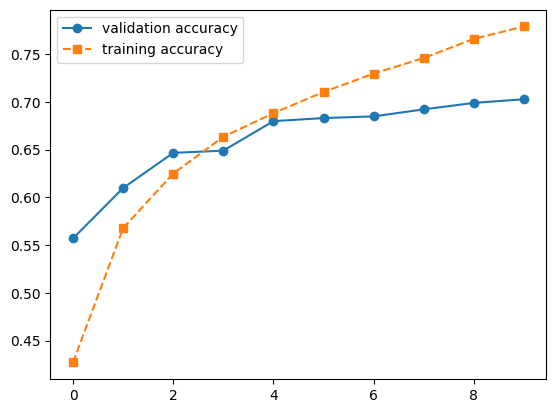

In [18]:
# Построим графики точности на валидационной (val_acc) и обучающей (acc) выборках
# в конце каждой эпохи обучения

plt.plot(history_cnn.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(history_cnn.history['accuracy'], '--s', label='training accuracy')
plt.legend();

In [19]:
# Выведем метрики качества нашей нейросети (функцию ошибки и точность)
# для тестовой выборки

base_model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7026 - loss: 0.8737


[0.8737156987190247, 0.7026000022888184]

[0.6708500981330872, 0.7799000144004822]

## 2) Переобучение. Аугментация данных

Еще один способ решения (помимо известного нам на данный момент Dropout) проблемы переобучения сети - аугментация ("увеличение") тренировочного датасета без привлечения реальных новых картинок.
 
Попробуем изменять наши исходные картинки перед тем, как они попадут в сетку при помощи различных трансформаций.

Конечно, можно было бы поштучно изменить каждую картинку, сохранить, как новый датасет и тренировать модель уже на нем.

Но это дает меньшую вариативность преобразований, занимает много места и памяти. Чтобы не изменять каждую картинку вручную, используют генераторы.

Создадим такой генератор на основе наших данных при помощи модуля из `keras` библиотеки `ImageDataGenerator`.

### 4. Генератор батчей с трансформацией

In [20]:
# Импортируем нужную нам модель генератора
from keras.preprocessing.image import ImageDataGenerator

ImportError: cannot import name 'ImageDataGenerator' from 'keras.preprocessing.image' (/home/sasha/miniconda3/envs/cv_course/lib/python3.13/site-packages/keras/preprocessing/image/__init__.py)

Создадим модуль ImageDataGenerator.

В качестве параметров укажем, какие изменения для картинок будем использовать.

В данном случае:

**width_shift_range**=0.1 - случайный сдвиг изображения по горизонтали на 0.1 ширины;

**height_shift_range**=0.1 - случайный сдвиг изображения по вертикали на 0.1 высоты;

**horizontal_flip**=True - случайно отражает картинку по гоизонтали

Таким образом, мы увеличиваем наш датасет, давая нейросети большую вариативность входных данных.

In [53]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

Применим полученные трансформации к нашим исходным данным.


Обратите внимание, что размер батча нужно указать здесь, чтобы генератор знал, 
сколько картинок ему выдавать модели при обучении.

Теперь при обращении к `train_generator` мы сможем получать измененные изображения.

При помощи метода `flow` получим генератор, связанный с нашими данными

In [54]:
train_generator = datagen.flow(X_train, y_train, batch_size=128)

`train_generator` является итератором, т.е., чтобы получить батч элементов
нужно выполнить какую-то итерирующую функцию: например, цикл `for`.

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

# ✅ Слой аугментации (полная замена ImageDataGenerator)
data_augmentation = keras.Sequential([
    layers.RandomTranslation(0.1, 0.1),   # width_shift + height_shift
    layers.RandomFlip("horizontal")       # horizontal_flip
])

# ✅ Dataset вместо datagen.flow()
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(10000).batch(128)

# ✅ Применяем аугментацию
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)


2025-12-04 16:31:37.135212: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-04 16:31:47.899054: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


NameError: name 'tf' is not defined

In [55]:
for img, label in train_dataset:
    break
img = img[0]

In [21]:
# Построим 8х8 трансформированных элементов нашего датасета
# при помощи функции plot_dataset_samples_grid

plot_dataset_samples_grid(img, dataset_name='transformed CIFAR10', N=8)

NameError: name 'img' is not defined

In [57]:
# Определим новую модель
gen_model = define_model()

In [ ]:
history_cnn = gen_model.fit(
    train_dataset,
    epochs=4,
    validation_data=(X_test, y_test)
)


In [69]:
#  Обучим модель с данными из генератора при помощи .fit_generator,

# На выходе все так же мы получим натренированную модель и структуру history_cnn, 
# из которой можно достать значения функции ошибки и метрик качества на обеих выборках
history_cnn = gen_model.fit_generator(train_generator,
                        epochs=4,
                        validation_data=(X_test, y_test))

Epoch 1/4
391/391 [==============================] - 63s 161ms/step - loss: 0.8142 - accuracy: 0.7154 - val_loss: 0.7299 - val_accuracy: 0.7474
Epoch 2/4
391/391 [==============================] - 63s 160ms/step - loss: 0.8075 - accuracy: 0.7160 - val_loss: 0.7280 - val_accuracy: 0.7411
Epoch 3/4
391/391 [==============================] - 65s 166ms/step - loss: 0.8078 - accuracy: 0.7172 - val_loss: 0.7153 - val_accuracy: 0.7489
Epoch 4/4
391/391 [==============================] - 65s 166ms/step - loss: 0.7992 - accuracy: 0.7187 - val_loss: 0.7101 - val_accuracy: 0.7527


In [60]:
history_cnn.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

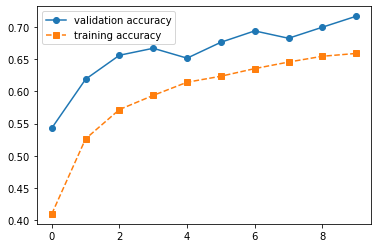

In [61]:
# Посмотрим на изменение точности на валидационной (val_acc) и обучающей (acc) выборках
# с каждой эпохой

plt.plot(history_cnn.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(history_cnn.history['accuracy'], '--s', label='training accuracy')
plt.legend();

In [62]:
gen_model.evaluate(X_test, y_test)

313/313 [==============================] - 3s 10ms/step - loss: 0.8175 - accuracy: 0.7162


[0.8175358772277832, 0.7161999940872192]

[0.7134924530982971, 0.7554000020027161]


Видно, что точность на валидационной выборке еще не вышла на "плато", а модель не успела переобучиться, значит, 
при увеличении числа эпох тренировки есть возможность увеличить точность на валидационном наборе данных.

Таким образом, при помощи аугментации удалось преодолеть проблему переобучения.